# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных

    id — уникальный идентификатор скважины;
    
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    
    product — объём запасов в скважине (тыс. баррелей).
    
    
### Условия задачи


    - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
    - Бюджет на разработку скважин в регионе — 10 млрд рублей.
    - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats as st


RANDOM_STATE = 0


In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

display('data_0')
data_0.info()
display(data_0.head(8))
display('data_1')
data_1.info()
display(data_1.head(8))
display('data_2')
data_2.info()
display(data_2.head(8))

'data_0'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292


'data_1'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522


'data_2'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640


Посмотрим дубли.

In [3]:
print('Количество дубликатов в data_0:', data_0.duplicated().sum())
print('Количество дубликатов в data_1:', data_1.duplicated().sum())
print('Количество дубликатов в data_2:', data_2.duplicated().sum())

Количество дубликатов в data_0: 0
Количество дубликатов в data_1: 0
Количество дубликатов в data_2: 0


In [4]:
print('Количество дубликатов по id в data_0:', data_0.duplicated(subset=['id']).sum())
print('Количество дубликатов по id в data_1:', data_1.duplicated(subset=['id']).sum())
print('Количество дубликатов по id в data_2:', data_2.duplicated(subset=['id']).sum())

Количество дубликатов по id в data_0: 10
Количество дубликатов по id в data_1: 4
Количество дубликатов по id в data_2: 4


In [5]:
data_0 = data_0.drop_duplicates(subset=['id'])
data_1 = data_1.drop_duplicates(subset=['id'])
data_2 = data_2.drop_duplicates(subset=['id'])

Поскольку теперь 'id' нам не нужен, удалю этот столбец из всех таблиц.


In [6]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

В столбце product должны быть положительные значения, потому что это объём добываемого ресурса, он не может быть отрицательным. Про параметры f нам ничего такого неизвестно, они такие, как есть. На их значения будем пристальней смотреть в диапазоне размаха. Проверим разброс значений.

In [7]:
display('data_0:', data_0.describe())
display('data_1:', data_1.describe())
display('data_2:', data_2.describe())

'data_0:'

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


'data_1:'

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'data_2:'

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


Да, добыча имеет положительные значения.

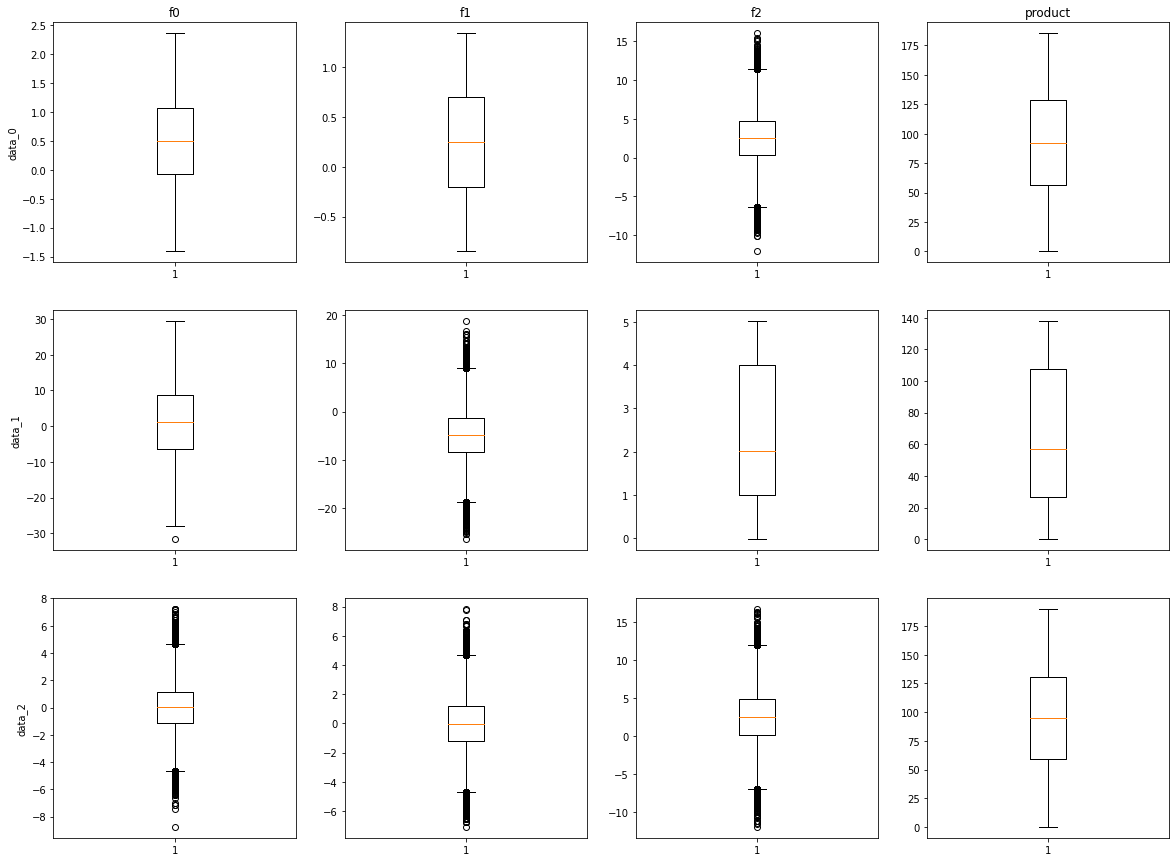

In [8]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_df = ["data_0","data_1","data_2"]
num_columns = data_0.columns
num_columns_with_columns = zip(data_0.columns,range(4))
all_df_with_rows = zip([data_0,data_1,data_2],range(3))

# графики

for column in list(itertools.product(all_df_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
    
# название таблицы

for row in range(3):
    ax[row][0].set_ylabel(all_df[row])
    
# название столбца

for column in range(4):
    ax[0][column].set_title(num_columns[column])

Визуально наблюдаем много выбросов в data_0 f2, data_1 f1, data_2 все параметры. И какой-то одинокий выброс в data_1 f0.

Надо бы их удалить.

In [9]:
    before = len(data_0)
    # граничные значения
    
    q1 = data_0['f2'].quantile(.25)
    q3 = data_0['f2'].quantile(.75)
    low = q1 - 1.5*(q3 - q1)
    high = q3 + 1.5*(q3 - q1)
    
    # перезапись того, что внутри значений
    data_0_clr = data_0.loc[(data_0['f2']>=low) & (data_0['f2']<=high)]
    after = len(data_0_clr)
    print('Процент отброшенных данных в выборке:', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
    print('Было строк:', before)

Процент отброшенных данных в выборке: 0.51 %
количество отброшенных строк: 506
Было строк: 99990


In [10]:
data_0_clr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99484 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99484 non-null  float64
 1   f1       99484 non-null  float64
 2   f2       99484 non-null  float64
 3   product  99484 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [11]:
    before = len(data_1)
    # граничные значения
    
    q1 = data_1['f0'].quantile(.25)
    q3 = data_1['f0'].quantile(.75)
    low = q1 - 1.5*(q3 - q1)
    high = q3 + 1.5*(q3 - q1)
    
    # перезапись того, что внутри значений
    df_clr = data_1.loc[(data_1['f0']>=low) & (data_1['f0']<=high)]
    after = len(df_clr)
    print('Процент отброшенных данных в выборке:', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
    print('Должно стать строк:', after)

Процент отброшенных данных в выборке: 0.0 %
количество отброшенных строк: 1
Должно стать строк: 99995


In [12]:
    before = len(df_clr)
    # граничные значения
    
    q1 = data_1['f1'].quantile(.25)
    q3 = data_1['f1'].quantile(.75)
    low = q1 - 1.5*(q3 - q1)
    high = q3 + 1.5*(q3 - q1)
    
    # перезапись того, что внутри значений
    data_1_clr = df_clr.loc[(df_clr['f1']>=low) & (df_clr['f1']<=high)]
    after = len(data_1_clr)
    print('Процент отброшенных данных в выборке:', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
    print('Должно стать строк:', after)
    

Процент отброшенных данных в выборке: 0.64 %
количество отброшенных строк: 636
Должно стать строк: 99359


In [13]:
data_1_clr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99359 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99359 non-null  float64
 1   f1       99359 non-null  float64
 2   f2       99359 non-null  float64
 3   product  99359 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [14]:
    before = len(data_2)
    # граничные значения
    
    q1 = data_2['f0'].quantile(.25)
    q3 = data_2['f0'].quantile(.75)
    low = q1 - 1.5*(q3 - q1)
    high = q3 + 1.5*(q3 - q1)
    
    # перезапись того, что внутри значений
    df_clr = data_2.loc[(data_2['f0']>=low) & (data_2['f0']<=high)].copy()
    after = len(df_clr)
    print('Процент отброшенных данных в выборке:', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
    print('Должно стать строк:', after)

Процент отброшенных данных в выборке: 0.73 %
количество отброшенных строк: 733
Должно стать строк: 99263


In [15]:
    before = len(df_clr)
    # граничные значения
    
    q1 = data_2['f1'].quantile(.25)
    q3 = data_2['f1'].quantile(.75)
    low = q1 - 1.5*(q3 - q1)
    high = q3 + 1.5*(q3 - q1)
    
    # перезапись того, что внутри значений
    df_clr = df_clr.loc[(df_clr['f1']>=low) & (df_clr['f1']<=high)].copy()
    after = len(df_clr)
    print('Процент отброшенных данных в выборке:', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
    print('Должно стать строк:', after)

Процент отброшенных данных в выборке: 0.69 %
количество отброшенных строк: 681
Должно стать строк: 98582


In [16]:
    before = len(df_clr)
    # граничные значения
    
    q1 = data_2['f2'].quantile(.25)
    q3 = data_2['f2'].quantile(.75)
    low = q1 - 1.5*(q3 - q1)
    high = q3 + 1.5*(q3 - q1)
    
    # перезапись того, что внутри значений
    data_2_clr = df_clr.loc[(df_clr['f2']>=low) & (df_clr['f2']<=high)].copy()
    after = len(data_2_clr)
    print('Процент отброшенных данных в выборке:', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
    print('Должно стать строк:', after)

Процент отброшенных данных в выборке: 0.59 %
количество отброшенных строк: 582
Должно стать строк: 98000


In [17]:
data_2_clr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       98000 non-null  float64
 1   f1       98000 non-null  float64
 2   f2       98000 non-null  float64
 3   product  98000 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


Суммарно отброшено не более 3 % данных для одного региона, это не должно исказить дальнейшие изыскания.

Рассмотрим матрицу корреляций для каждого региона.


In [18]:
def correlation(df):
    df_corr = df.corr()
    sns.heatmap(df_corr , xticklabels=df_corr.columns, yticklabels=df_corr.columns, annot=True)

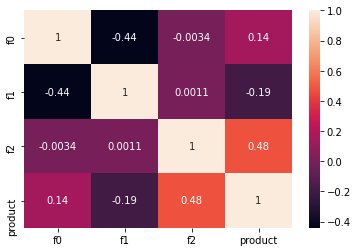

In [19]:
correlation(data_0_clr)    

Здесь мы видим обратную корреляцию между признаками f1 и f0 и прямую между f2 и product.

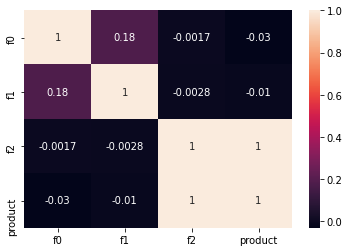

In [20]:
correlation(data_1_clr)    

Mежду целевым признаком и f2 есть высокая прямая корреляция.


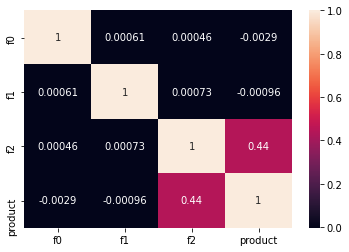

In [21]:
correlation(data_2_clr)    

Здесь также прямая корреляция между f2 и product.

Всё. Дубли по скважинам удалены, учтены разбросы и корреляции, теперь можно приступать к обучению моделей.

## Обучение и проверка модели

### Разбиение выборок на обучающую, валидационную и тестовую

Поскольку у нас три датасета, напишу функцию для дальнейшей работы.

In [22]:
def separate(data, data_name, test_size_valid, target_feature):
    
    # 
    
    features = data.drop(target_feature, axis=1)
    target = data[target_feature]
    
    #
    
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                target, test_size=test_size_valid, random_state=RANDOM_STATE)
    
    print(f'Размеры выборок для {data_name}:\n_____________________________')

    print('features_valid:', features_valid.shape)
    print('target_valid:', target_valid.shape)
    print('features_train:', features_train.shape)
    print('target_train:', target_train.shape)
    print('_____________________________\n')
    return features_valid, target_valid, features_train, target_train
    


In [23]:

test_size_valid = 0.25
target_feature = 'product'
data_name = ['data_0_clr', 'data_1_clr', 'data_2_clr']



In [24]:
features_valid_0, target_valid_0, features_train_0, target_train_0 = separate(data_0_clr, data_name[0], test_size_valid, target_feature)
features_valid_1, target_valid_1, features_train_1, target_train_1 = separate(data_1_clr, data_name[1], test_size_valid, target_feature)
features_valid_2, target_valid_2, features_train_2, target_train_2 = separate(data_2_clr, data_name[2], test_size_valid, target_feature)

Размеры выборок для data_0_clr:
_____________________________
features_valid: (24871, 3)
target_valid: (24871,)
features_train: (74613, 3)
target_train: (74613,)
_____________________________

Размеры выборок для data_1_clr:
_____________________________
features_valid: (24840, 3)
target_valid: (24840,)
features_train: (74519, 3)
target_train: (74519,)
_____________________________

Размеры выборок для data_2_clr:
_____________________________
features_valid: (24500, 3)
target_valid: (24500,)
features_train: (73500, 3)
target_train: (73500,)
_____________________________



И теперь надо стандартизировать каждую.

In [25]:
# data_to_scale = [features_valid, features_train]
def scale_data(features_valid, features_train):
    scaler = StandardScaler()
    scaler.fit(features_train)

    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)

    return features_valid, features_train

In [26]:
features_valid_0, features_train_0 = scale_data(features_valid_0, features_train_0)
features_valid_1, features_train_1 = scale_data(features_valid_1, features_train_1)
features_valid_2, features_train_2 = scale_data(features_valid_2, features_train_2)

### Обучение модели

In [27]:
def study_model(data_name, features_valid, target_valid, features_train, target_train):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    mse_v = mean_squared_error(target_valid, predicted_valid)
    rmse_v = mse_v ** 0.5

    print(f'для выборки {data_name}\n')
    print("RMSE =", rmse_v)
    print('Средняя добыча:', predicted_valid.mean())
    print('___________________\n')
    
    
    return model, predicted_valid.mean(), predicted_valid

In [28]:
model_0, mean_0, predict_0 = study_model(data_name[0], features_valid_0, target_valid_0, features_train_0, target_train_0)
model_1, mean_1, predict_1 = study_model(data_name[1], features_valid_1, target_valid_1, features_train_1, target_train_1)
model_2, mean_2, predict_2 = study_model(data_name[2], features_valid_2, target_valid_2, features_train_2, target_train_2)

для выборки data_0_clr

RMSE = 37.70681752824511
Средняя добыча: 92.5084815165794
___________________

для выборки data_1_clr

RMSE = 0.892938466308693
Средняя добыча: 69.07803125241199
___________________

для выборки data_2_clr

RMSE = 40.17595283670293
Средняя добыча: 95.07139658346769
___________________



    По среднему объёму регионы выстроились по убыванию в следующем порядке:
        - Регион 2
        - Регион 0
        - Регион 1
        
    Ошибка распределена также.

## Подготовка к расчёту прибыли

На один регион выделяется бюджет в 10 млн рублей

In [29]:
REGION_BUGET = 10*(10**9)
MEGABARREL_PRICE = 450000
# в таблице представлена добыча в тысячах баррелей 
WELLS_NEED = 200

print('Расчётный объём средней добычи со скважины для безубыточности региона = ', round(REGION_BUGET/(WELLS_NEED*MEGABARREL_PRICE), 2))

Расчётный объём средней добычи со скважины для безубыточности региона =  111.11


In [30]:
print(f'Средние запасы по регионам: \n\tРегион 0 = {round(mean_0, 2)}\n\tРегион 1 = {round(mean_1, 2)}\n\tРегион 2 = {round(mean_2, 2)}')

Средние запасы по регионам: 
	Регион 0 = 92.51
	Регион 1 = 69.08
	Регион 2 = 95.07


Везде маловато, особенно в регионе 1.

## Расчёт прибыли и рисков 

Функция расчёта прибыли:

In [31]:
def profit(target, predict, cost, count):
    predict = pd.Series(predict)
    probs_sorted = predict.sort_values(ascending=False)

    selected = target[probs_sorted.index][:count] * cost
    
    return selected.sum() - REGION_BUGET

Воспользуемся методом bootstrap и сгенерируем 1000 выборок для нахождения распределения средней прибыли.

In [32]:
def print_res(region_name, mean, low, high, risk):
    print(region_name, '\n----------------')
    print("Средняя выручка (200 лучших скважин):", round(mean, 0))
    print("95% доверительный интервал:", round(low,0), '-', round(high,0))
    print("Риск убытков:", risk, '%')
    print('----------------\n')

In [33]:


predict_0_pd = pd.Series(predict_0, index=target_valid_0.index)
predict_1_pd = pd.Series(predict_1, index=target_valid_1.index)
predict_2_pd = pd.Series(predict_2, index=target_valid_2.index)



In [34]:
def bootstrap_def(region_name: str, target: pd.Series, prediction: pd.Series) -> tuple:
    
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        
        
        prediction_subsample = prediction[target_subsample.index]
    
        values.append(profit(target_subsample, prediction_subsample, MEGABARREL_PRICE, 200))

    values = pd.Series(values)
    ##
    mean = values.mean()
    low = values.quantile(.025)
    high = values.quantile(.975)
    risk = st.percentileofscore(values, 0) 
    
    print_res(region_name, mean, low, high, risk)
    return mean, low, high, risk

    



In [35]:
mean_oil_0, low_0, high_0, risk_0 = bootstrap_def('Регион 0', target_valid_0, predict_0_pd)
mean_oil_1, low_1, high_1, risk_1 = bootstrap_def('Регион 1', target_valid_1, predict_1_pd)
mean_oil_2, low_2, high_2, risk_2 = bootstrap_def('Регион 2', target_valid_2, predict_2_pd)

Регион 0 
----------------
Средняя выручка (200 лучших скважин): 464061755.0
95% доверительный интервал: -61230866.0 - 985085375.0
Риск убытков: 4.5 %
----------------

Регион 1 
----------------
Средняя выручка (200 лучших скважин): 547191186.0
95% доверительный интервал: 146462852.0 - 945990393.0
Риск убытков: 0.5 %
----------------

Регион 2 
----------------
Средняя выручка (200 лучших скважин): 309525250.0
95% доверительный интервал: -237174846.0 - 853424964.0
Риск убытков: 14.5 %
----------------



Регион 1 единственный удовлетворяет по безопасности - риск убытков в пять раз меньше установленного, как максимального. И расчётная прибыль на нём также максимальна. И всё это не смотря на то, что по средней добыче Регион 1 на последнем месте из рассматриваемых.

Вывод: к разработке рекомендован Регион 1